In [1]:
'''步驟總覽
設定 Kaggle Notebook 環境
下載並準備資料集
轉換標註格式為 YOLO
建立 data.yaml 設定檔
下載 YOLOv8 並訓練模型
測試訓練好的模型'''

'步驟總覽\n設定 Kaggle Notebook 環境\n下載並準備資料集\n轉換標註格式為 YOLO\n建立 data.yaml 設定檔\n下載 YOLOv8 並訓練模型\n測試訓練好的模型'

In [2]:
#安裝套件
!pip install torch>=2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pytorch-lightning==2.5.0
!pip install ultralytics

# 安裝 paddleocr 和 paddlepaddle
!pip install paddlepaddle-gpu
!pip install "paddleocr>=2.0.1"

In [3]:
import os

dataset_path = "/kaggle/input/car-plate-detection"

print("📂 檢查資料集內容:", os.listdir(dataset_path))

📂 檢查資料集內容: ['annotations', 'images']


In [4]:
os.makedirs("/kaggle/working/images/train", exist_ok=True)
print("資料夾建立成功")

資料夾建立成功


In [5]:
import os
import glob
import shutil
import xml.etree.ElementTree as ET

# ✅ 確保類別名稱和 data.yaml 一致
classes = ["licence"]  # 注意: 確保 data.yaml 內也是 "licence"

# ✅ 設定標註與影像路徑
annotation_dir = "/kaggle/input/car-plate-detection/annotations"
image_dir = "/kaggle/input/car-plate-detection/images"
output_img_dir = "/kaggle/working/images/train"
output_label_dir = "/kaggle/working/labels/train"

# ✅ 確保輸出資料夾存在
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

def convert_xml_to_yolo_and_copy_images(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    img_filename = root.find("filename").text
    img_path = os.path.join(image_dir, img_filename)

    # ✅ 檢查影像是否存在
    if not os.path.exists(img_path):
        print(f"⚠️ 影像檔案不存在：{img_path}，跳過！")
        return

    # 複製影像到目標資料夾
    output_img_path = os.path.join(output_img_dir, img_filename)
    shutil.copy(img_path, output_img_path)

    # ✅ 讀取影像大小
    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    yolo_annotations = []

    for obj in root.findall("object"):
        label = obj.find("name").text
        if label not in classes:
            print(f"⚠️ {img_filename} 的標註 `{label}` 未包含在 classes 清單內，已跳過")
            continue
        
        class_id = classes.index(label)
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # ✅ 轉換為 YOLO 格式 (相對座標)
        x_center = (xmin + xmax) / 2 / img_w
        y_center = (ymin + ymax) / 2 / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # ✅ 確保 `.txt` 檔案名稱對應影像名稱
    txt_filename = os.path.splitext(img_filename)[0] + ".txt"
    txt_file = os.path.join(output_label_dir, txt_filename)

    if yolo_annotations:
        with open(txt_file, "w") as f:
            f.write("\n".join(yolo_annotations))
    else:
        print(f"⚠️ {txt_filename} 無有效標註，已跳過")

# 🔄 開始轉換 XML 並複製影像
xml_files = glob.glob(f"{annotation_dir}/*.xml")
for xml in xml_files:
    convert_xml_to_yolo_and_copy_images(xml)

print("✅ XML 轉換及影像複製完成！")

✅ XML 轉換及影像複製完成！


In [6]:
yaml_content = """\
train: /kaggle/working/images/train
val: /kaggle/working/images/train

nc: 1
names: ['licence']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml 設定檔已建立！")

✅ data.yaml 設定檔已建立！


In [7]:
from ultralytics import YOLO

# 下載 YOLOv8 預訓練權重
model = YOLO("yolov8n.pt")

# 訓練 YOLO
model.train(data="/kaggle/working/data.yaml", epochs=100, imgsz=640)

Ultralytics 8.3.73 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /kaggle/working/labels/train.cache... 433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 433/433 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/train.cache... 433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 433/433 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.21G      1.519       2.98      1.308          1        640: 100%|██████████| 28/28 [00:07<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.86it/s]

                   all        433        471    0.00336      0.928      0.456      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.19G      1.485      1.953      1.219          3        640: 100%|██████████| 28/28 [00:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


                   all        433        471      0.687      0.191      0.364      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.2G      1.503      1.767       1.24          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]


                   all        433        471      0.815      0.459      0.589        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.19G      1.604        1.7      1.337          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


                   all        433        471      0.499      0.528      0.466      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.19G      1.572      1.528      1.318          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


                   all        433        471      0.713       0.66      0.701      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.2G        1.5      1.443      1.288          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]


                   all        433        471      0.772       0.59      0.689      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.19G      1.459      1.336      1.286          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.94it/s]


                   all        433        471      0.741      0.817      0.839      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.19G      1.475      1.287      1.262          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]


                   all        433        471      0.603      0.607      0.564      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.18G      1.447      1.198      1.253          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


                   all        433        471      0.733      0.786      0.767       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.23G      1.473      1.152      1.304          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]


                   all        433        471      0.877      0.641       0.77      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.18G      1.399      1.048      1.251          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


                   all        433        471      0.892      0.805      0.898      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.18G      1.386      1.031      1.232          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

                   all        433        471      0.842      0.824      0.909      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.18G      1.458      1.034      1.284          3        640: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.92it/s]

                   all        433        471      0.811      0.849       0.89      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.18G      1.375     0.9758      1.238          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.02it/s]

                   all        433        471      0.875      0.815      0.877        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.2G      1.372     0.9487       1.24          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]

                   all        433        471      0.877      0.867      0.921      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.18G      1.321     0.9448      1.219          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]

                   all        433        471      0.873      0.854       0.92      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.18G       1.35     0.9426      1.215          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.02it/s]

                   all        433        471      0.906      0.801      0.903      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.18G      1.366      0.938      1.235          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

                   all        433        471      0.836      0.868       0.92      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.18G      1.354     0.9305      1.194          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.01it/s]

                   all        433        471      0.883      0.881      0.943      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.18G      1.298     0.8698      1.183          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

                   all        433        471      0.894      0.893      0.938      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.18G      1.305     0.8651      1.188          3        640: 100%|██████████| 28/28 [00:05<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]

                   all        433        471       0.87      0.896      0.929      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.18G       1.32     0.8705        1.2          4        640: 100%|██████████| 28/28 [00:05<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]

                   all        433        471      0.839      0.887      0.932       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.18G      1.317     0.8395      1.196          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

                   all        433        471      0.922      0.866      0.939      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.22G      1.292     0.8933      1.168          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]

                   all        433        471      0.901      0.929      0.961      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.2G      1.302     0.8294      1.169          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]

                   all        433        471      0.884      0.893      0.927       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.2G      1.326     0.7809      1.174          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.86it/s]

                   all        433        471      0.854      0.919      0.939      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.18G      1.241      0.783      1.168          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.915      0.928      0.946      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.2G      1.288     0.8136      1.169          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.89it/s]

                   all        433        471      0.913      0.897      0.943      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.18G      1.239     0.7637      1.183          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

                   all        433        471      0.919      0.898      0.952       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.2G      1.196     0.8136      1.126          0        640: 100%|██████████| 28/28 [00:06<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.92it/s]

                   all        433        471      0.929      0.913      0.954      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.2G      1.245     0.7675      1.165          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]

                   all        433        471       0.91      0.945       0.96      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.18G      1.247     0.7615      1.177          3        640: 100%|██████████| 28/28 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

                   all        433        471       0.92      0.926       0.96      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.18G      1.193     0.7336      1.147          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]

                   all        433        471      0.892      0.953      0.958      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.18G      1.241     0.7496      1.145          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]

                   all        433        471      0.942      0.933      0.965      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.2G      1.261     0.7493      1.185          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.924      0.959      0.971      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.2G      1.286     0.7762      1.219          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]

                   all        433        471      0.916      0.949      0.965      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.18G      1.181     0.7093      1.132          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.89it/s]

                   all        433        471      0.939      0.948      0.975      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.18G      1.249      0.727      1.173          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.943      0.945      0.961      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.18G      1.202     0.7258      1.137          3        640: 100%|██████████| 28/28 [00:05<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.86it/s]

                   all        433        471      0.924      0.943      0.965      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.18G      1.191     0.6923      1.131          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

                   all        433        471      0.892      0.945      0.963       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.18G      1.146     0.6998      1.099          0        640: 100%|██████████| 28/28 [00:05<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.946      0.945      0.982       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.2G       1.18     0.7001      1.127          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]

                   all        433        471      0.938      0.947      0.982      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.18G      1.199     0.6945      1.121          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]

                   all        433        471      0.936      0.953      0.976      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.18G      1.174     0.6921       1.11          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.91it/s]

                   all        433        471      0.944      0.968      0.981      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.22G      1.139      0.688      1.093          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

                   all        433        471       0.95      0.932      0.973      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.18G       1.14     0.6639      1.095          3        640: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

                   all        433        471      0.955       0.94      0.966      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.18G      1.115     0.6648      1.105          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]

                   all        433        471      0.918       0.95      0.967      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.18G      1.173     0.6913      1.122          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        433        471      0.942      0.972      0.967      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.18G      1.101      0.642      1.097          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]

                   all        433        471      0.962       0.97       0.98      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.18G      1.156     0.6809      1.126          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]

                   all        433        471      0.949      0.947      0.968      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.18G      1.141     0.6476      1.089          5        640: 100%|██████████| 28/28 [00:05<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

                   all        433        471      0.921      0.964      0.964      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.18G      1.116     0.6494      1.092          3        640: 100%|██████████| 28/28 [00:05<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.87it/s]

                   all        433        471      0.957      0.981      0.985      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.18G      1.077     0.6246       1.09          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.02it/s]

                   all        433        471      0.954      0.977      0.976      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.18G      1.131     0.6318      1.116          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]

                   all        433        471      0.954      0.983      0.985      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.18G      1.071     0.6139      1.088          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

                   all        433        471      0.956      0.981       0.98      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.18G      1.082      0.616      1.091          3        640: 100%|██████████| 28/28 [00:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

                   all        433        471      0.948      0.979      0.979      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.18G      1.104     0.6329      1.087          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.05it/s]

                   all        433        471       0.97      0.977      0.981      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.18G      1.019     0.5917      1.068          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.02it/s]

                   all        433        471      0.966      0.979      0.983       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.18G      1.076     0.6125      1.069          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.01it/s]

                   all        433        471      0.961      0.983      0.984      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.18G      1.083     0.5933      1.098          4        640: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.98it/s]

                   all        433        471       0.96      0.979      0.984      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.18G      1.109     0.7103      1.121          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

                   all        433        471      0.968      0.981      0.988      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.18G      1.081     0.5971      1.095          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.956      0.978      0.988      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.18G      1.045     0.5631      1.059          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.99it/s]

                   all        433        471      0.942      0.972      0.969      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.18G      1.063     0.5969      1.067          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.964      0.972      0.986      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.18G     0.9996     0.5847      1.059          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

                   all        433        471      0.958      0.975      0.984      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.18G     0.9958      0.645      1.027          0        640: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.07it/s]

                   all        433        471      0.962      0.975      0.986      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.18G      1.036     0.5516      1.068          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

                   all        433        471      0.961      0.977      0.986      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.18G      1.004     0.5698      1.054          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

                   all        433        471      0.954      0.978      0.987       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.18G      1.015     0.5659      1.069          2        640: 100%|██████████| 28/28 [00:05<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.01it/s]

                   all        433        471      0.945      0.983      0.983      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.18G       1.04     0.5688      1.044          3        640: 100%|██████████| 28/28 [00:05<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]

                   all        433        471      0.963      0.985      0.986      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.18G       1.01     0.5922      1.076          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

                   all        433        471      0.958      0.992      0.988      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.2G      1.025     0.5652      1.058          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

                   all        433        471      0.969      0.983      0.985      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.18G     0.9637     0.5166      1.059          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]

                   all        433        471      0.961      0.986      0.986      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.18G     0.9589     0.5457      1.034          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.02it/s]

                   all        433        471      0.961      0.992      0.989      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.18G     0.9733     0.5378      1.031          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

                   all        433        471      0.961      0.993      0.989      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.18G     0.9193      0.516      1.024          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]

                   all        433        471      0.971      0.988       0.99      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.18G      1.011     0.5294      1.059          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.89it/s]

                   all        433        471      0.973      0.985      0.989      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.2G      1.016     0.5541      1.063          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

                   all        433        471      0.973      0.987      0.989      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.18G     0.9101     0.5042      1.008          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

                   all        433        471      0.974      0.987       0.99      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.18G     0.9322      0.498      1.018          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.88it/s]

                   all        433        471      0.957      0.993      0.989      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.22G     0.9536     0.5404      1.021          3        640: 100%|██████████| 28/28 [00:05<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]

                   all        433        471      0.957      0.989      0.987      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.18G      1.017     0.5787      1.028          2        640: 100%|██████████| 28/28 [00:06<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

                   all        433        471      0.958      0.994      0.988      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.18G     0.9181      0.498      1.014          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]

                   all        433        471      0.968      0.977       0.99       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.18G     0.9602     0.5305      1.023          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.90it/s]

                   all        433        471      0.969      0.983      0.989      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.18G     0.9086     0.4937      1.006          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

                   all        433        471      0.967      0.994       0.99      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.18G     0.9318     0.5003      1.024          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

                   all        433        471      0.974      0.985       0.99      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.18G     0.9097     0.4949      1.023          2        640: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.92it/s]

                   all        433        471      0.974      0.989      0.991      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       2.2G     0.8765     0.4874      1.004          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]

                   all        433        471      0.972      0.985       0.99      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.18G     0.8944     0.4934      1.003          4        640: 100%|██████████| 28/28 [00:05<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]

                   all        433        471      0.969      0.987      0.989      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.18G     0.9179     0.4891       1.03          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

                   all        433        471      0.974      0.996       0.99      0.789


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.18G     0.9485     0.5037      1.012          1        640: 100%|██████████| 28/28 [00:06<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]

                   all        433        471      0.963      0.989      0.989       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.18G     0.9199     0.4862      1.005          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.93it/s]

                   all        433        471      0.963      0.989      0.989      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.18G     0.8703     0.4482     0.9836          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

                   all        433        471      0.967      0.993       0.99      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.2G      0.846     0.4398     0.9905          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.99it/s]

                   all        433        471      0.973      0.988      0.991      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.18G      0.833     0.4404     0.9894          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.96it/s]

                   all        433        471      0.974      0.987      0.991      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.18G     0.9122     0.4389      1.014          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]

                   all        433        471      0.975      0.989      0.992      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.18G     0.8816     0.4339      1.021          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]

                   all        433        471      0.971       0.99       0.99      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.18G     0.8182     0.4239     0.9695          1        640: 100%|██████████| 28/28 [00:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]

                   all        433        471      0.971      0.996      0.991      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.18G     0.8274     0.4346     0.9786          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]

                   all        433        471      0.973      0.989      0.991        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.18G     0.8259     0.4237     0.9758          1        640: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

                   all        433        471       0.98      0.987      0.991      0.803



100 epochs completed in 0.278 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


                   all        433        471       0.98      0.987      0.991      0.802


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787a06cb15a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

[2025/02/09 17:15:29] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_ch

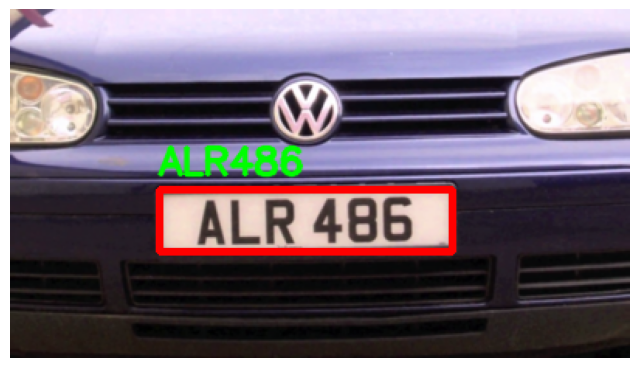

車牌 1: ALR486

image 1/1 /kaggle/input/car-plate-detection/images/Cars135.png: 384x640 1 licence, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
[2025/02/09 17:15:32] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010364770889282227
[2025/02/09 17:15:32] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 17:15:32] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


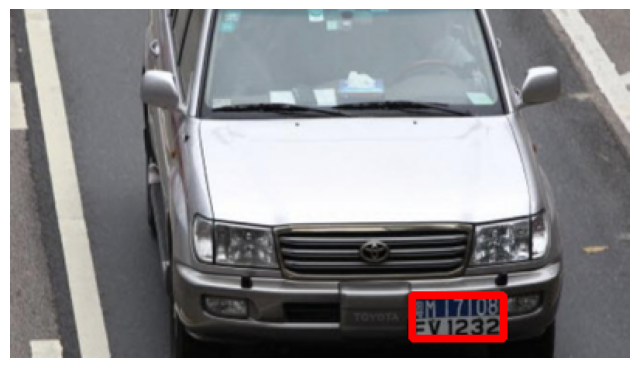

車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars383.png: 448x640 1 licence, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/09 17:15:32] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010465621948242188
[2025/02/09 17:15:32] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 17:15:32] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


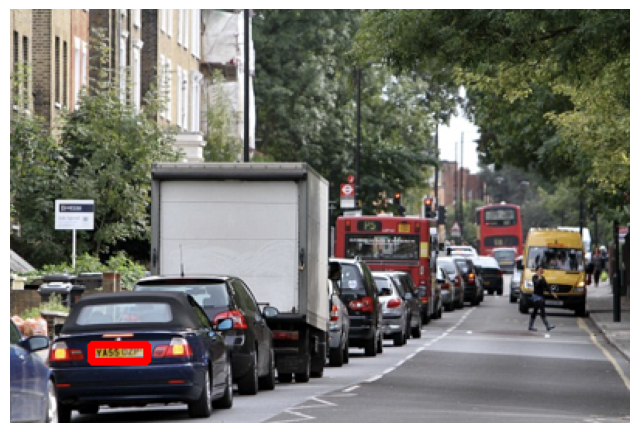

車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars193.png: 448x640 1 licence, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/09 17:15:33] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.011400461196899414
[2025/02/09 17:15:33] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 17:15:33] ppocr DEBUG: rec_res num  : 0, elapsed : 3.337860107421875e-06


車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars251.png: 384x640 1 licence, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
[2025/02/09 17:15:33] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010431528091430664
[2025/02/09 17:15:33] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 17:15:33] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars166.png: 640x480 1 licence, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
[2025/02/09 17:15:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011206388473510742
[2025/02/09 17:15:33] ppocr DEBUG: cls num  : 1, elapsed : 0.007368326187133789
[2025/02/09 17:15:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.010016441345214844


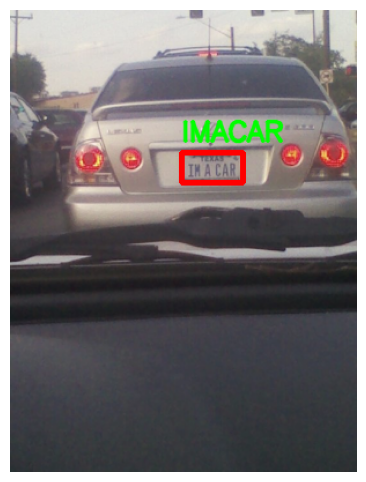

車牌 1: IMACAR

image 1/1 /kaggle/input/car-plate-detection/images/Cars64.png: 448x640 1 licence, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/09 17:15:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012221097946166992
[2025/02/09 17:15:33] ppocr DEBUG: cls num  : 1, elapsed : 0.0073816776275634766
[2025/02/09 17:15:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.01017308235168457


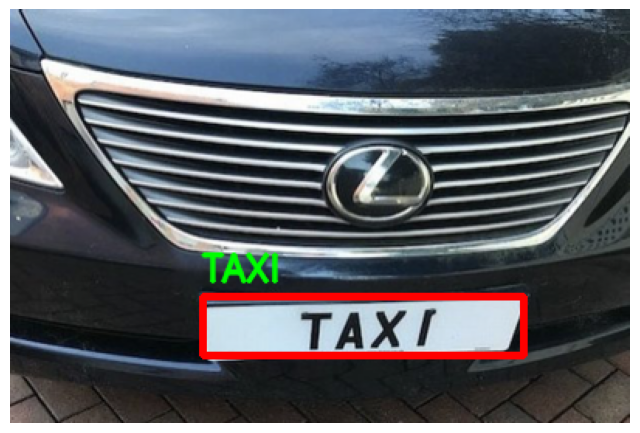

車牌 1: TAXI

image 1/1 /kaggle/input/car-plate-detection/images/Cars357.png: 448x640 1 licence, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/09 17:15:34] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010301828384399414
[2025/02/09 17:15:34] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 17:15:34] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars214.png: 416x640 1 licence, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
[2025/02/09 17:15:34] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010243415832519531
[2025/02/09 17:15:34] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 17:15:34] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06


車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars422.png: 384x640 1 licence, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
[2025/02/09 17:15:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011548757553100586
[2025/02/09 17:15:34] ppocr DEBUG: cls num  : 1, elapsed : 0.007296323776245117
[2025/02/09 17:15:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.009959220886230469


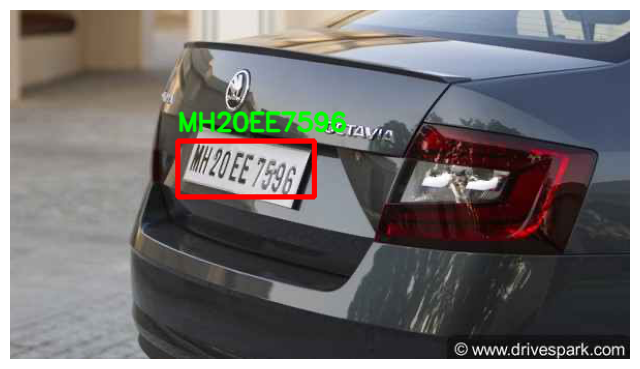

車牌 1: MH20EE7596


In [25]:
from ultralytics import YOLO
import cv2
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR, draw_ocr

# 載入 YOLO 模型（使用 train9 的最佳權重）
model = YOLO("runs/detect/train9/weights/best.pt")

# 初始化 PaddleOCR（支援中文及英文字母辨識）
ocr = PaddleOCR(use_angle_cls=True, lang="ch")

# 取得所有圖片路徑（依據副檔名搜尋）
image_paths = glob.glob("/kaggle/input/car-plate-detection/images/*.png") + \
              glob.glob("/kaggle/input/car-plate-detection/images/*.jpg")

# 隨機選擇最多 10 張圖片來測試
num_images = min(10, len(image_paths))
random_images = random.sample(image_paths, num_images)

# 開始處理圖片
for img_path in random_images:
    # 讀取圖片
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換為 RGB 避免色彩顛倒

    # 使用 YOLO 模型進行車牌偵測
    results = model(img_path)

    # 儲存辨識的車牌文字
    detected_text_list = []

    # 遍歷所有偵測結果
    for result in results:
        boxes = result.boxes  # 取得所有偵測到的邊界框
        for box in boxes:
            # 取得邊界框座標（轉換為整數）
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()
            conf = box.conf[0].item()  # 取得置信度

            # 擷取車牌區域
            plate_img = img[y1:y2, x1:x2]

            # 可選擇轉換為灰階圖片
            gray_plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

            # 使用 PaddleOCR 辨識車牌文字
            ocr_results = ocr.ocr(gray_plate_img, cls=True) or []
            detected_text = ""
            # 遍歷 OCR 結果，每個 line 可能為 None 或空值，因此先做檢查
            for line in ocr_results:
                if not line:
                    continue
                # 每個 line 內的元素也可能為 None，因此逐一檢查
                for word in line:
                    if word is None:
                        continue
                    # 取得辨識文字，這裡假設 word[1] 為 tuple，且第 0 個元素為車牌文字
                    detected_text = word[1][0]
            
            # 在圖片上繪製偵測框（藍色）
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 3)
            # 在圖片上方顯示辨識文字（綠色字體）
            cv2.putText(img_rgb, detected_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
            # 儲存辨識結果
            detected_text_list.append(detected_text)

    # 顯示結果圖片
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    # 印出每一個辨識出的車牌文字
    for i, text in enumerate(detected_text_list):
        print(f"車牌 {i+1}: {text}")